In [2]:
import pandas as pd
import numpy as np

# Loading the data

## Loading trips.csv

Dataset at the center of the diagram linking the routes, the stop times, the shapes and the calendar.

In [3]:
trips_data = pd.read_csv('../../data/gtfs23Sept/trips.csv', sep=",")
trips_data.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,14,237259001,113275577237259001,JULES BORDET,0,8934823,069b0002
1,14,237259001,113275578237259001,JULES BORDET,0,8934827,069b0002
2,14,237259001,113275579237259001,JULES BORDET,0,8934823,069b0002
3,14,237259001,113275580237259001,BORDET STATION,0,8934822,069b0005
4,14,237259001,113275581237259001,JULES BORDET,0,8934826,069b0002


## Loading routes.csv

Dataset containing transportation classes (tram, bus, metro) in order to select only trams.

In [4]:
routes_data = pd.read_csv('../../data/gtfs23Sept/routes.csv', sep=",")

print(routes_data['route_type'].unique())
# print(np.unique(routes_data['route_type']))

routes_data.head()

[1 0 3]


,route_id,route_short_name,route_long_name,route_type,route_color,route_text_color
0,1,1,GARE DE L'OUEST - STOCKEL,1,B5378C,FFFFFF
1,4,2,SIMONIS - ELISABETH,1,ED6C23,FFFFFF
2,5,3,ESPLANADE - CHURCHILL,0,B4BD10,000000
3,8,4,GARE DU NORD - STALLE (P),0,EA4F80,000000
4,2,5,ERASME - HERRMANN-DEBROUX,1,F6A90B,FFFFFF


We can observe that there are only 3 types (which matches our 3 tram, bus and metros types). Using the column `route_long_name`, we were able to verify that:

| `route_type` |  **Type** |
|--------------|:---------:|
| 0            |  **Tram** |
| 1            | **Metro** |
| 3            |  **Bus**  |

## Loading stop_times.csv

Dataset containing the exact times at which a vehicle arrives at/departs from a stop, for every vehicle for every line.

Given that we are trying to plot, for **every stop** of **both directions** of **every line**, the **arrival time** of a given transportation vehicle. We take the arrival time (different from the departure time) because it's the time that matters to passengers.

In [5]:
stop_times_data = pd.read_csv('../../data/gtfs23Sept/stop_times.csv', sep=",")
stop_times_data.head()

# print(stop_times_data['route_type'].unique())

<ipython-input-5-7696884e884f>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times_data = pd.read_csv('../../data/gtfs23Sept/stop_times.csv', sep=",")


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,113275577237259001,08:52:00,08:52:00,3107,1,0,0
1,113275577237259001,08:53:00,08:53:00,3177,2,0,0
2,113275577237259001,08:54:03,08:54:03,3171,3,0,0
3,113275577237259001,08:55:30,08:55:30,3172,4,0,0
4,113275577237259001,08:56:18,08:56:18,3173,5,0,0


We will attempt to join the tables in order to filter out metros and buses, given that trams are the vehicle type that we are studying.

In [69]:
trips_routes_merge = pd.merge(trips_data, routes_data, on='route_id')
trips_routes_merge = trips_routes_merge[['trip_id', 'service_id', 'route_type', 'route_short_name', 'trip_headsign', 'direction_id']]
trips_routes_merge = trips_routes_merge.loc[trips_routes_merge['route_type'] == 3]
trips_routes_merge.head()
# trips_routes_merge.tail()

,trip_id,service_id,route_type,route_short_name,trip_headsign,direction_id
0,113275577237259001,237259001,3,69,JULES BORDET,0
1,113275578237259001,237259001,3,69,JULES BORDET,0
2,113275579237259001,237259001,3,69,JULES BORDET,0
3,113275580237259001,237259001,3,69,BORDET STATION,0
4,113275581237259001,237259001,3,69,JULES BORDET,0


We have successfully linked (tram) routes to all other possible datasets.

### TODO: verify hypothesis that monday = weekday (that 1 1 1 1 1 = 1)

In [70]:
calendar_data = pd.read_csv('../../data/gtfs23Sept/calendar.csv', sep=",")
trips_routes_calendar = pd.merge(trips_routes_merge, calendar_data, on='service_id')
trips_routes_calendar.drop(['end_date', 'tuesday', 'wednesday', 'thursday', 'friday', 'service_id'], inplace=True, axis=1)
trips_routes_calendar.rename(columns={'monday': 'weekday'}, inplace=True)  #TODO hypothesis: monday = weekday
trips_routes_calendar.tail()

,trip_id,route_type,route_short_name,trip_headsign,direction_id,weekday,saturday,sunday,start_date
40580,113713837239004002,3,T82,DROGENBOS CHATEAU,0,1,0,0,20211011
40581,113713838239004002,3,T82,DROGENBOS CHATEAU,0,1,0,0,20211011
40582,113713839239004002,3,T82,DROGENBOS CHATEAU,0,1,0,0,20211011
40583,113713840239004002,3,T82,DROGENBOS CHATEAU,0,1,0,0,20211011
40584,113713842239004002,3,T82,DROGENBOS CHATEAU,0,1,0,0,20211011


Now that we have linked calendar and routes, we will now further link it to stop times.

In [71]:
print(len(trips_routes_calendar))
trcst = pd.merge(stop_times_data, trips_routes_calendar, on='trip_id',how="inner")
print(len(trcst))
trcst.drop(['pickup_type', 'drop_off_type', 'stop_sequence', 'departure_time', 'trip_id'], inplace=True, axis=1)
trcst.head(30)
# trcst.tail()

trcsttemp = trcst.loc[(trcst['route_short_name'] == '28')] # 
trcsttemp.head()


40585
892995


,arrival_time,stop_id,route_type,route_short_name,trip_headsign,direction_id,weekday,saturday,sunday,start_date
74398,06:25:00,1830,3,28,BRABANCONNE,1,1,0,0,20210920
74399,06:25:16,1832,3,28,BRABANCONNE,1,1,0,0,20210920
74400,06:26:00,1833B,3,28,BRABANCONNE,1,1,0,0,20210920
74401,06:27:11,1451,3,28,BRABANCONNE,1,1,0,0,20210920
74402,06:28:09,1450,3,28,BRABANCONNE,1,1,0,0,20210920


Say we take Tram 3 direction CHURCHILL at stop 5701.

In [72]:
from math import ceil, floor
from statistics import mean

import matplotlib.pyplot as plt


def get_times(direction:int, weekday:int, route_short_name:str, stop_id:str, start_date:int, dataframe:pd.DataFrame):
    data = dataframe.loc[(trcst['direction_id'] == direction) & (trcst['weekday'] == weekday) & (trcst['route_short_name'] == route_short_name) & (trcst['stop_id'] == stop_id)  & (trcst['start_date'] == start_date)]
    return data['arrival_time'].tolist()

def time_to_sec(time:str) -> int:
    time = time.split(":")
    hours, minutes, seconds = int(time[0]), int(time[1]), int(time[2])
    return hours*60*60+minutes*60+seconds

def map_to_min(arrival_times:list):
    arrival_times_minutes = map(time_to_sec, arrival_times)
    arrival_times_minutes = list(arrival_times_minutes)
    return sorted(arrival_times_minutes)

def get_xy(arrival_times_minutes):
    x, y = [], []
    for i in range(len(arrival_times_minutes)-1):
        y.append(round((arrival_times_minutes[i+1]-arrival_times_minutes[i])/60, 2))
        x.append(round(arrival_times_minutes[i]/3600, 2))
    return x, y

def gradient(y):
    output = []
    for i in range(len(y)-1):
        value = y[i+1]-y[i]
        if value:
            output.append(1)
        else:
            output.append(0)
    output.append(1)
    return output

def get_interval(x, y):
    index = 0
    lines = [x[0]]
    y = gradient(y)
    i = 0

    while i < len(y)-5:

        mode = "zero" if sum(y[i:i+7]) < 4 else "diff"
        temp = 0
        start = index

        if mode == "diff":
            count_zeros = 0
            while (count_zeros < 4 or start + 4 > index) and i < len(y): # creating the diff zone
                if y[i]:
                    if temp >= 2:
                        count_zeros = 0
                        temp = 0
                    elif count_zeros:
                        temp+=1
                elif index != i:
                    if not count_zeros:
                        index = i
                    count_zeros += 1
                i+=1    

        elif mode == "zero":
            count_diff = 0
            while (count_diff < 1 or start + 4 > index) and i < len(y):
                if y[i]: 
                    if not count_diff:
                        index = i
                    count_diff += 1
                elif temp > 2:
                    count_diff = 0
                    temp = 0
                elif count_diff:
                    temp +=1
                i+=1

        if index > len(y) - 4:
            index = len(y)-1
            i = index + 1
        elif i < len(y):
            i = index + 1
        else:
            index = len(y)-1
        lines.append(x[index])
        count_diff = 0
        count_zeros = 0
            
    if x[-1] not in lines:
        lines.append(x[-1])
    return lines

def seb_algo(x, y):
    lines = get_interval(x, y)
    return lines

def diego_lines(x, y):
    s_y = smoothen(y, 2, 2)
    d_y = [0] + [abs(s_y[j+1]-s_y[j]) for j in range(len(s_y)-1)]
    line_list = [x[0]]
    for j in range(1, len(x)):
        if d_y[j] >= 2:
            line_list.append(x[j])
    line_list.append(x[-1])
    return line_list

def smoothen(input_list, step, depth):
    if depth == 0:
        return input_list
    output_list = []
    for idx in range(len(input_list)):
        min_idx = max(0, idx-step)
        max_idx = min(len(input_list), idx+step)
        subset = input_list[min_idx:max_idx+1]
        if subset.count(input_list[idx]) >= 2:
            output_list.append(input_list[idx])
        elif max(abs(input_list[idx]-max(subset)), abs(input_list[idx]-max(subset))) <= 1:
            idx_number = max_idx - min_idx
            idx_mean = sum([input_list[idx_2] for idx_2 in range(min_idx, max_idx)])
            idx_mean /= idx_number
            output_list.append(idx_mean)
        else:
            output_list.append(input_list[idx])
    return smoothen(output_list, step, depth-1)

def smoothen_weight(input_list, step, depth):
    if depth == 0:
        return input_list
    output_list = []
    for idx in range(len(input_list)):
        min_idx = max(0, idx-step)
        max_idx = min(len(input_list), idx+step)
        subset = input_list[min_idx:max_idx+1]
        idx_mean = sum(subset)/len(subset)
        if idx_mean == input_list[idx]:
            output_list.append(input_list[idx])
        else:
            mean_differences = [abs(idx_mean-idx_val) for idx_val in subset]
            # print(subset)
            max_mean_difference = max(mean_differences)
            closeness = [abs(m_diff-max_mean_difference) for m_diff in mean_differences]
            total_closeness = sum(closeness)
            weights = [c/total_closeness for c in closeness]
            elem = sum([subset[j]*weights[j] for j in range(len(subset))])
            output_list.append(elem)
    return smoothen_weight(output_list, step, depth-1)

def run_algos(dataframe:pd.DataFrame, examples:list):
    for example in examples:
        stop_id, route_short_name, start_date, direction, weekday = example
        times = get_times(direction, weekday, route_short_name, stop_id, start_date, dataframe)
        arrival_times = map_to_min(times)
        x, y = get_xy(arrival_times)
        lines_seb = seb_algo(x, y)
        lines_diego = diego_lines(x, y)
        # plt.subplot(1,2)
        plt.figure(figsize=[30,10])
        plot(x, y, lines_seb, direction, weekday, route_short_name, stop_id, start_date, "ALGO1", 1)
        plot(x, y, lines_diego, direction, weekday, route_short_name, stop_id, start_date, "ALGO2", 2)
        plt.show()
        

def plot(x, y, lines, direction, weekday, route_short_name, stop_id, start_date, name, order):
    title = f"{name} : Scheduled headways on line {route_short_name} to {direction} at the stop {stop_id} on {weekday} on the {start_date}"
    # plt.figure(figsize=[15,10])
    plt.subplot(1, 2, order)
    plt.bar(x, y, width=0.05)
    # plt.plot(x, y)
    for line in lines:
        plt.axvline(x = line, color = 'r', label = 'axvline - full height')
    plt.title(title)

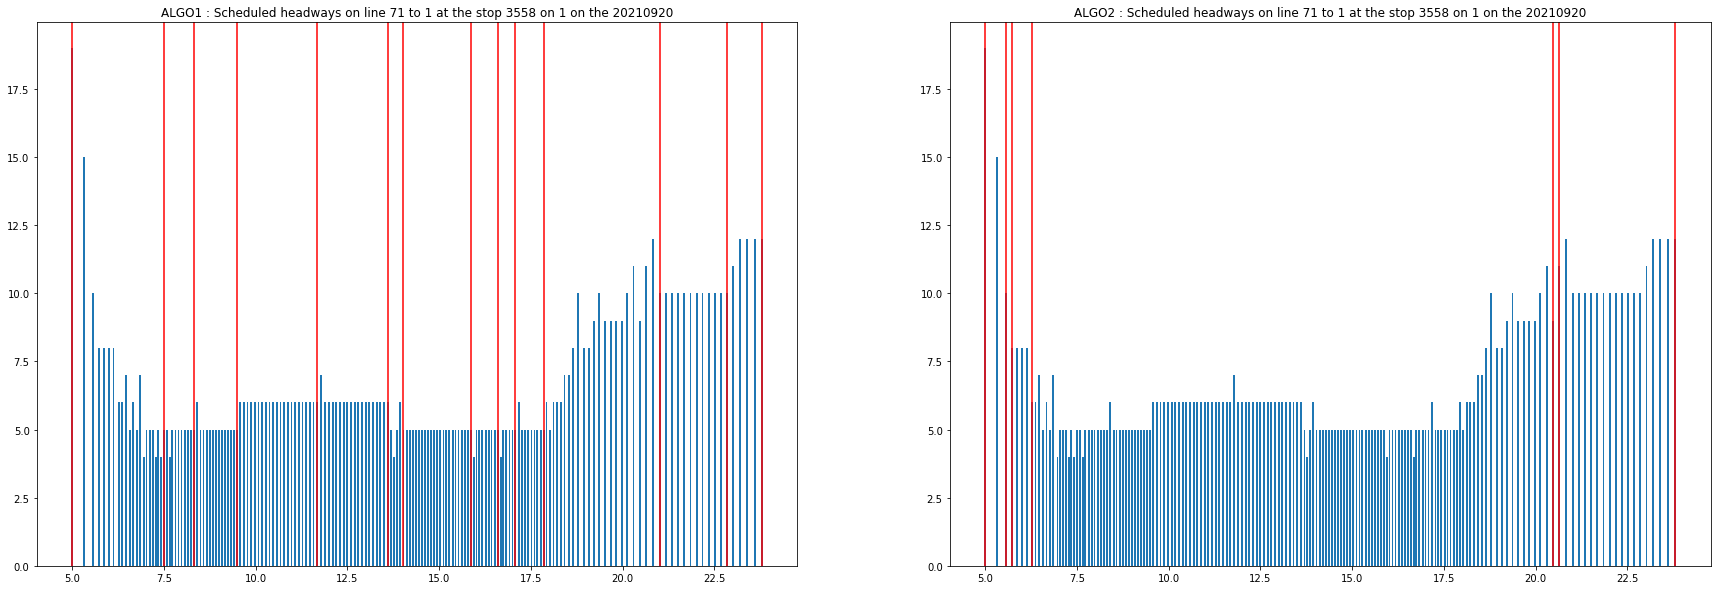

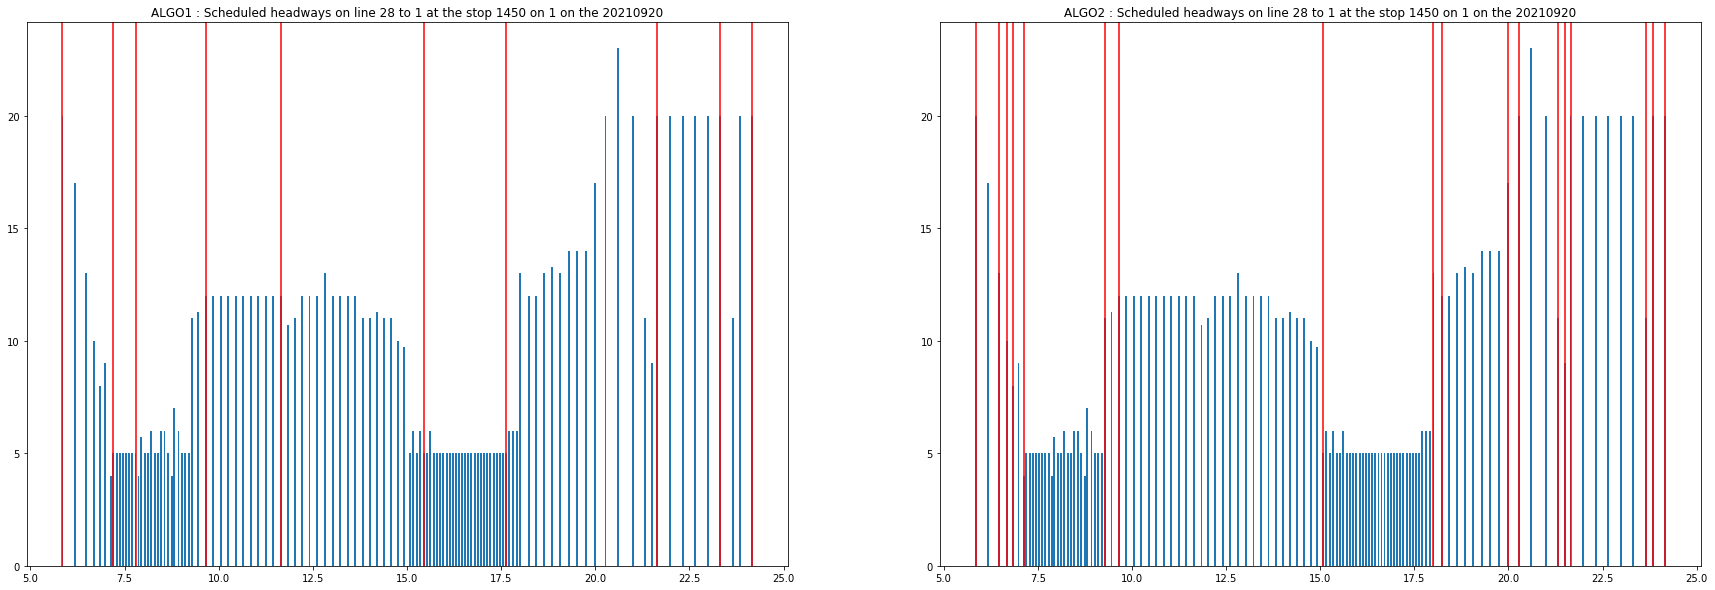

In [73]:
examples = [['0539', '25', 20210920, 1, 1], ['5705', "3", 20210920, 0, 1], ['5315', '92', 20210920, 0, 1], ['2397F', '8', 20210920, 0, 1], ['5521', '39', 20210920, 1, 1]] #tram
examples2 = [['8272', '1', 20211015, 0, 1] , ['8421', '2', 20211015, 1, 1], ['8682', '5', 20211015, 0, 1], ['8773', '6', 20211015, 1, 1]] #metro
examples3 = [['3558', '71', 20210920, 1, 1], ['1450', '28', 20210920, 1, 1]] #bus
run_algos(trcst, examples3)

In [24]:
stop_id = '1450'
line = '28'
date = 20210920
direction = 1
week = 1
examples = [['0539', '25', 20210920, 1, 1], ['5705', "3", 20210920, 0, 1], ['5315', '92', 20210920, 0, 1], ['2397F', '8', 20210920, 0, 1], ['5521', '39', 20210920, 1, 1]]
trcst2 = trcst.loc[(trcst['direction_id'] == direction) & (trcst['weekday'] == week) & (trcst['route_short_name'] == line) & (trcst['stop_id'] == stop_id)  & (trcst['start_date'] == date)]
trcst2.head()

trip_headsign = trcst['trip_headsign'].iat[0]
trcst2 = trcst2['arrival_time']
print(len(trcst2))
print(len(np.unique(trcst2)))
# trcst2.head()
arrival_times = trcst2.tolist()
print(sorted(arrival_times))



120
120
['05:51:09', '06:11:09', '06:28:09', '06:41:09', '06:51:09', '06:59:09', '07:08:09', '07:12:09', '07:17:09', '07:22:09', '07:27:09', '07:32:09', '07:37:09', '07:42:09', '07:47:09', '07:52:09', '07:56:09', '08:01:52', '08:06:52', '08:11:52', '08:17:52', '08:22:52', '08:27:52', '08:33:52', '08:39:52', '08:44:52', '08:48:52', '08:55:52', '09:01:52', '09:06:52', '09:11:52', '09:16:52', '09:27:52', '09:39:09', '09:51:09', '10:03:09', '10:15:09', '10:27:09', '10:39:09', '10:51:09', '11:03:09', '11:15:09', '11:27:09', '11:39:09', '11:51:09', '12:01:52', '12:12:52', '12:24:52', '12:36:52', '12:48:52', '13:01:52', '13:13:52', '13:25:52', '13:37:52', '13:49:52', '14:00:52', '14:11:52', '14:23:09', '14:34:09', '14:45:09', '14:55:09', '15:04:52', '15:09:52', '15:15:52', '15:20:52', '15:26:52', '15:31:52', '15:36:52', '15:42:52', '15:47:52', '15:52:52', '15:57:52', '16:02:52', '16:07:52', '16:12:52', '16:17:52', '16:22:52', '16:27:52', '16:32:52', '16:37:52', '16:42:52', '16:47:52', '16:52:

In [130]:
arrival_times_minutes = map(time_to_sec, arrival_times)
arrival_times_minutes = list(arrival_times_minutes)
arrival_times_minutes = sorted(arrival_times_minutes)
print(arrival_times_minutes)

[20324, 21284, 22244, 22784, 23444, 24104, 24644, 25124, 25484, 25844, 26084, 26384, 26744, 27104, 27464, 27824, 28184, 28544, 28904, 29264, 29624, 29984, 30344, 30704, 31064, 31424, 31784, 32204, 32564, 33044, 33464, 33704, 34244, 34424, 34844, 35444, 36044, 36644, 37244, 37844, 38444, 39044, 39704, 40244, 40724, 41204, 41684, 42104, 42584, 43004, 43484, 43904, 44384, 44864, 45344, 45824, 46244, 46724, 47204, 47684, 48164, 48524, 48884, 49304, 49724, 50204, 50624, 50984, 51464, 51944, 52364, 52904, 53264, 53624, 53984, 54344, 54704, 55064, 55424, 55724, 56084, 56444, 56804, 57164, 57524, 57884, 58244, 58664, 59024, 59384, 59744, 60104, 60464, 60824, 61184, 61544, 61904, 62324, 62684, 63044, 63404, 63764, 64124, 64484, 64844, 64964, 65384, 65804, 65984, 66464, 66944, 67424, 67904, 68384, 68864, 69344, 69884, 70484, 70664, 71084, 71684, 72044, 72584, 72824, 73784, 73964, 74984, 75224, 76304, 77504, 78704, 79904, 81104, 82364, 83564, 84764, 85964, 86744, 87704, 88904, 90344]


In [131]:
x, y = [], []
print(arrival_times_minutes[0+1]-arrival_times_minutes[0])
print(arrival_times_minutes[1+1]-arrival_times_minutes[1])
for i in range(len(arrival_times_minutes)-1):
    #if round((arrival_times_minutes[i+1]-arrival_times_minutes[i])/60, 2):
    y.append(round((arrival_times_minutes[i+1]-arrival_times_minutes[i])/60, 2))
    x.append(round(arrival_times_minutes[i]/3600, 2))

960
960


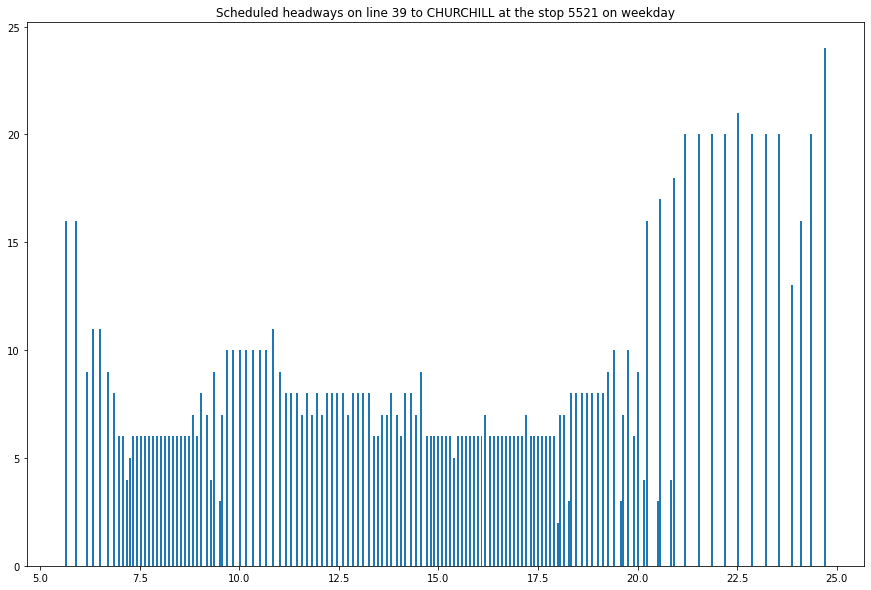

In [134]:
import matplotlib.pyplot as plt
title = f"Scheduled headways on line {line} to {trip_headsign} at the stop {stop_id} on weekday"
plt.figure(figsize=[15,10])
plt.bar(x, y, width=0.05)
plt.title(title)
plt.show()

In [61]:
from math import floor, ceil
from statistics import mean

def gradient(y):
    output = []
    for i in range(len(y)-1):
        value = y[i+1]-y[i]
        if value:
            output.append(1)
        else:
            output.append(0)
    output.append(1)
    return output

def mean_filter(y, k=3):
    output = [y[:floor(k/2)]] 
    output.extend(mean(y[i-floor(k/2):i+floor(k/2)]) for i in range(floor(k/2), len(y)-floor(k/2)))
    output.append(y[len(y)-floor(k/2):])
    return output

# def get_interval(x, y):
#     count_zeros = 0
#     count_diff = 0
#     index = 0
#     lines = [x[0]]
#     y = gradient(y)
#     i = 0

#     while i < len(y)-5:

#         mode = "zero" if sum(y[i:i+7]) < 4 else "diff"
#         temp = 0
#         start = index

#         if mode == "diff":
#             while (count_zeros < 4 or start + 4 > index) and i < len(y): # creating the diff zone
#                 if y[i]:
#                     if temp >= 1:
#                         count_zeros = 0
#                         temp = 0
#                     elif count_zeros:
#                         temp+=1
#                 elif index != i:
#                     if not count_zeros:
#                         index = i
#                     count_zeros += 1
#                 i+=1

#             lines.append(x[index])
#             count_zeros = 0
#             if i < len(y):
#                 i = index + 1

#         elif mode == "zero":
#             while (count_diff < 1 or start + 4 > index) and i < len(y):
#                 if y[i]: 
#                     if not count_diff:
#                         index = i
#                     count_diff += 1
#                 elif temp > 2:
#                     count_diff = 0
#                     temp = 0
#                 elif count_diff:
#                     temp +=1
#                 i+=1

#             lines.append(x[index])
#             count_diff = 0
#             if i < len(y):
#                 i = index + 1

#     if x[-1] not in lines:
#         lines.append(x[-1])
#     return lines

print(gradient(y))
title = f"Scheduled headways on line {line} to {trip_headsign} at the stop {stop_id} on weekday"
plt.figure(figsize=[15,10])
plt.bar(x, gradient(y), width=0.05)
plt.title(title)
plt.show()





NameError: name 'y' is not defined

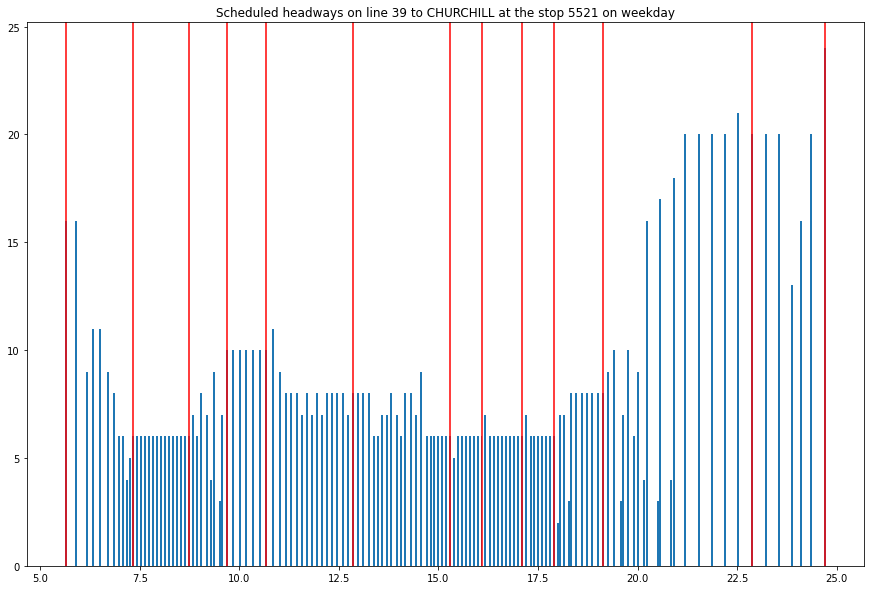

In [136]:


lines = get_interval(x, y)

title = f"Scheduled headways on line {line} to {trip_headsign} at the stop {stop_id} on weekday"
plt.figure(figsize=[15,10])
plt.bar(x, y, width=0.05)
# plt.plot(x, y)
for line in lines:
    plt.axvline(x = line, color = 'r', label = 'axvline - full height')
plt.title(title)
plt.show()
temp = gradient(y)
# print(lines)
# for i in range(len(y)):
#     print(i, temp[i], y[i], x[i])


        

In [139]:
print(lines)

[5.65, 7.33, 8.73, 9.68, 10.68, 12.85, 15.3, 16.08, 17.1, 17.91, 19.13, 22.88, 24.7]


In [113]:
z = list(zip(x,y))
z=np.array([list(x) for x in list(zip(x,y))])



In [114]:
from sklearn import cluster


#clustering = cluster.DBSCAN(eps=0.5, min_samples=20).fit(z)
#clustering = cluster.KMeans(n_clusters = 5, random_state=0).fit(z)
#clustering = cluster.Birch(n_clusters = None).fit(z)
#clustering = cluster.OPTICS(min_samples =20 ).fit(z)
#clustering = cluster.AffinityPropagation(random_state =0 ).fit(z)
clustering = cluster.MeanShift(bandwidth =3 ).fit(z)
#clustering = cluster.AgglomerativeClustering(5).fit(z)
labels = clustering.labels_
print(np.unique(labels))

[0 1 2 3 4 5]


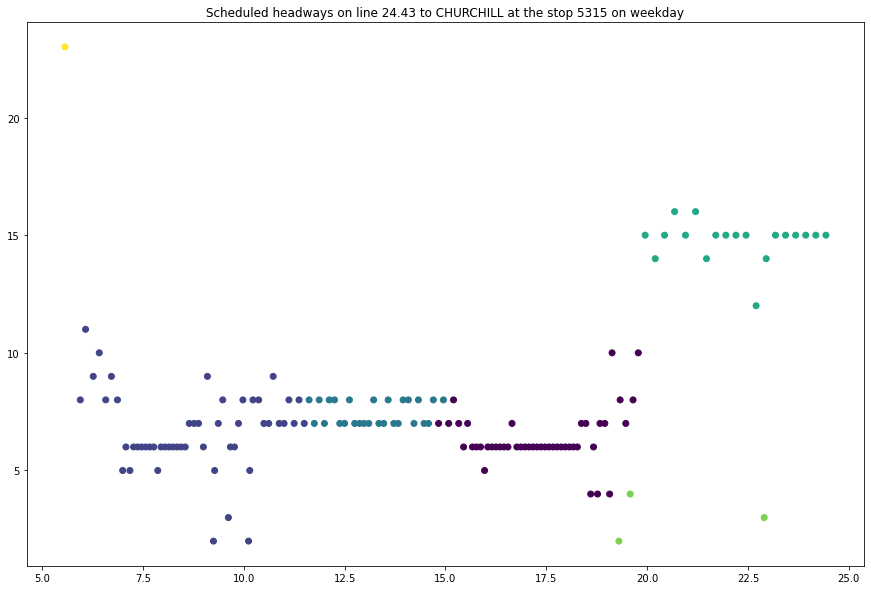

In [115]:
title = f"Scheduled headways on line {line} to {trip_headsign} at the stop {stop_id} on weekday"
plt.figure(figsize=[15,10])
plt.scatter(x, y, c=labels)
plt.title(title)
plt.show()